# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 16.7 MB/s 
     |████████████████████████████████| 185 kB 54.1 MB/s 
     |████████████████████████████████| 155 kB 54.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.4 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.4 which is incompatible.


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [ ]:
mnist = fetch_openml('mnist_784', cache=False)

In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X = pd.DataFrame.to_numpy(X)
print(type(X))

<class 'numpy.ndarray'>


To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

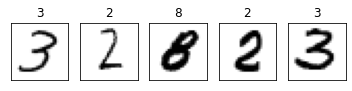

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
This network has two hidden layers: (hidden_dim1=100) and (hidden_dim2=80). The syntax is awful and very easy to make mistakes.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dim1 = 100
hidden_dim2 = 80
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dim1, hidden_dim2, output_dim

(784, 100, 80, 10)

A Neural network in PyTorch's framework.

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim1=hidden_dim1,
            hidden_dim2=hidden_dim2,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)
    def forward(self, X, **kwargs):
        X = F.relu(self.hidden2(F.relu(self.hidden1(X))))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [ ]:
print(ClassifierModule())

ClassifierModule(
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden1): Linear(in_features=784, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=80, bias=True)
  (output): Linear(in_features=80, out_features=10, bias=True)
)


In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0294       0.8698        0.4400  1.9748
      2        0.4403       0.9069        0.3153  1.7692
      3        0.3435       0.9140        0.2784  1.7528
      4        0.2850       0.9379        0.2070  1.7384
      5        0.2453       0.9452        0.1769  1.7040
      6        0.2135       0.9528        0.1594  1.8743
      7        0.1912       0.9545        0.1503  1.8298
      8        0.1711       0.9594        0.1378  1.7426
      9        0.1562       0.9597        0.1341  1.7058
     10        0.1436       0.9638        0.1203  1.7264
     11        0.1346       0.9632        0.1190  1.8374
     12        0.1223       0.9657        0.1128  1.8326
     13        0.1155       0.9657        0.1125  1.7632
     14        0.1062       0.9674        0.1066  2.9142
     15        0.1013       0.9686        0.1037  1.7583
     16        0.0941       0.9

## Prediction

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9698285714285714

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

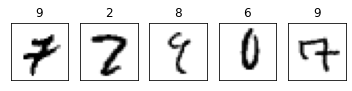

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)


        self.conv2_drop = nn.Dropout2d(p=dropout)
        # First fully connected layer
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [ ]:
print(Cnn())

Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc1_drop): Dropout(p=0.5, inplace=False)
)


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3865       0.9759        0.0770  34.4211
      2        0.1398       0.9826        0.0566  35.2544
      3        0.1105       0.9834        0.0534  34.2419
      4        0.0961       0.9870        0.0416  33.9821
      5        0.0845       0.9870        0.0424  33.7145
      6        0.0802       0.9885        0.0390  35.0138
      7        0.0740       0.9896        0.0353  34.3681
      8        0.0703       0.9892        0.0340  34.0228
      9        0.0664       0.9889        0.0369  33.7109
     10        0.0616       0.9888        0.0372  34.0242


In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

0.9882285714285715

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7386363636363636

Over 70% of the previously misclassified images are now correctly identified.

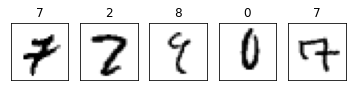

In [ ]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])

# Your turn


*   Learn to add layers to the ANN. See example above.
*   Learn to change the number of filters in the CNN; i.e., kernel sizes.  You can also play with dropout but I am not entirely sure the effects are visible.

